In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product
from sklearn.metrics import mean_absolute_error, mean_squared_error

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = pd.read_excel('нефть-brent 2010-2019.xlsx')
data.head(5)

,Datetime,Value
0,2019-09-01,58.84
1,2019-08-30,59.19
2,2019-08-29,60.37
3,2019-08-28,59.84
4,2019-08-27,59.59


In [3]:
data["Datetime"]=pd.to_datetime(data.Datetime)
data.head(5)

,Datetime,Value
0,2019-09-01,58.84
1,2019-08-30,59.19
2,2019-08-29,60.37
3,2019-08-28,59.84
4,2019-08-27,59.59


In [4]:
data['date_minus_time'] = data["Datetime"].apply( lambda data : 
datetime.datetime(year=data.year, month=data.month, day=data.day))
data.set_index(data["date_minus_time"],inplace=True)
data.head(5)

,Datetime,Value,date_minus_time
date_minus_time,,,
2019-09-01,2019-09-01,58.84,2019-09-01
2019-08-30,2019-08-30,59.19,2019-08-30
2019-08-29,2019-08-29,60.37,2019-08-29
2019-08-28,2019-08-28,59.84,2019-08-28
2019-08-27,2019-08-27,59.59,2019-08-27


In [5]:
data = data.resample('W', on = 'date_minus_time').sum()
data

,Value
date_minus_time,
2010-09-05,383.08
2010-09-12,466.04
2010-09-19,472.16
2010-09-26,471.11
2010-10-03,487.27
2010-10-10,504.88
2010-10-17,500.99
2010-10-24,496.77
2010-10-31,500.17


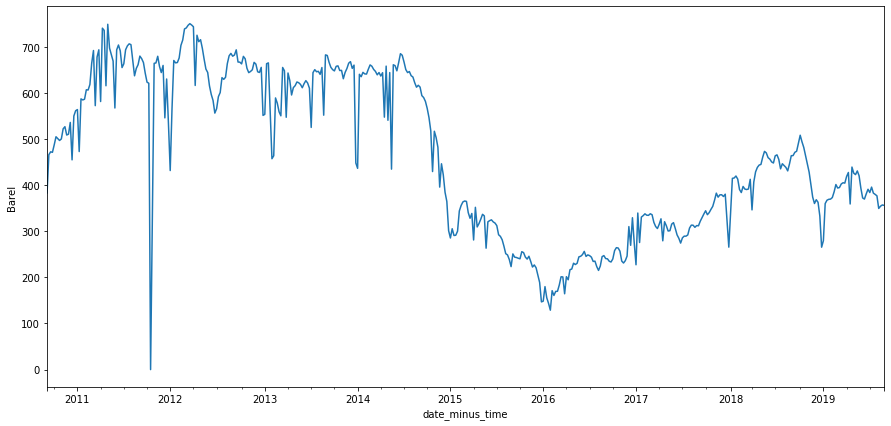

In [6]:
plt.figure(figsize(15,7))
data['Value'].plot()
plt.ylabel('Barel')
pylab.show()

In [7]:
def code_mean(data, cat_feature, real_feature):
    return dict(data.groupby(cat_feature)[real_feature].mean())

In [8]:
data["weekday"] = data.index.weekday
data['is_weekend'] = data.weekday.isin([5,6])*1
data.head()

,Value,weekday,is_weekend
date_minus_time,,,
2010-09-05,383.08,6,1
2010-09-12,466.04,6,1
2010-09-19,472.16,6,1
2010-09-26,471.11,6,1
2010-10-03,487.27,6,1


In [9]:

def prepareData(data, lag_start=5, lag_end=20, test_size=0.15):

    data = pd.DataFrame(data.copy())
    data.columns = ["y"]

    # считаем индекс в датафрейме, после которого начинается тестовыый отрезок
    test_index = int(len(data)*(1-test_size))

    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)

#     data.index = data.index.to_datetime()
#     data["hour"] = data.index.hour
    data["weekday"] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5,6])*1

    # считаем средние только по тренировочной части, чтобы избежать лика
    data['weekday_average'] = list(map(code_mean(data[:test_index], 'weekday', "y").get, data.weekday))
#     data["hour_average"] = list(map(code_mean(data[:test_index], 'hour', "y").get, data.hour))

    # выкидываем закодированные средними признаки 
#     data.drop(["hour", "weekday"], axis=1, inplace=True)
    data.drop(["weekday"], axis=1, inplace=True)

    data = data.dropna()
    data = data.reset_index(drop=True)

    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["y"], axis=1)
    y_train = data.loc[:test_index]["y"]
    X_test = data.loc[test_index:].drop(["y"], axis=1)
    y_test = data.loc[test_index:]["y"]

    return X_train, X_test, y_train, y_test

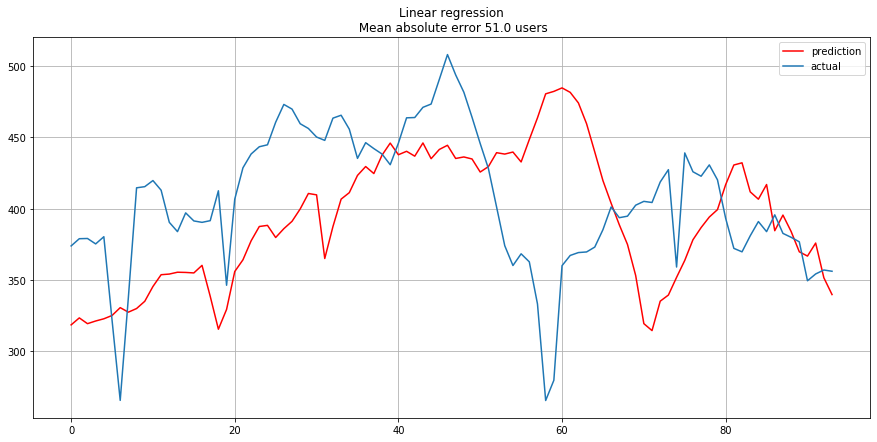

In [11]:
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = prepareData(data['Value'], test_size=0.3, lag_start=12, lag_end=48)
lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)
plt.figure(figsize=(15, 7))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression\n Mean absolute error {} users".format(round(mean_absolute_error(prediction, y_test))))
plt.grid(True);